Download the data, set pandas datetime series. 

In [5]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.ticker as mtick

coin = "BTCUSDT"  # change here for other coin ticker symbol
number = 15000   # will not work if downlaoded data is smaller than number here
percentage = 25/100
series = pd.DataFrame(data=None)
try:
    series[list({"date","price"})] = pd.read_csv("https://www.cryptodatadownload.com/cdd/Binance_" + coin + "_1h.csv",skiprows = 1)[list({"date","close"})][:number]
    print("downloaded data:")
    series["date"] = pd.to_datetime(series["date"]) 
    series = series[::-1]
    print(series.tail())  # check downloaded data
    print("working with ",len(series), " entries") 
except:
        print("some issues with download. Exiting...")
        SystemExit


downloaded data:
                 date     price
4 2022-08-27 20:00:00  20007.99
3 2022-08-27 21:00:00  19873.06
2 2022-08-27 22:00:00  20020.08
1 2022-08-27 23:00:00  20037.60
0 2022-08-28 00:00:00  20039.62
working with  15000  entries


Calculation part:

In [6]:
coindip = []
coindipdate = []
lastprice = 0
lastdate = ""
dipstend = []
dipstendprice = []
mindipdate = []
minpricestack = []
j = 0
minprice = series.iloc[0]['price']
mindate = series.iloc[0]['date']
lastprice = series.iloc[0]['price']
lastdate = series.iloc[0]['date']
insidecoindip = False
for i in range(1,len(series)):
    if i % 500 == 0:
        print(i,". price: ", series.iloc[i]['price'], " date: ", series.iloc[i]['date'], " last price: ",lastprice, " coindip: ", '\033[94m', insidecoindip, '\033[0m')
    if minprice > series.iloc[i]['price']:
        minprice = series.iloc[i]['price']
        mindate = series.iloc[i]['date']

    if (insidecoindip == True and series.iloc[i]['price'] >= lastprice ):
        insidecoindip = False
        dipstend.append(series.iloc[i]['date'])
        dipstendprice.append(coindip[-1])  
        minpricestack.append(minprice)
        mindipdate.append(mindate)

    if series.iloc[i]['price'] < lastprice * (1- percentage):    
        if insidecoindip == False:
            insidecoindip = True
            coindip.append(lastprice)
            coindipdate.append(lastdate)
            j += 1
    else: 
        if series.iloc[i]['price'] > lastprice:
            lastprice = series.iloc[i]['price']
            lastdate = series.iloc[i]['date']
            minprice = series.iloc[i]['price']
            insidecoindip = False
            continue

if insidecoindip == True:
    dipstend.append(series.iloc[i]['date'])
    dipstendprice.append(0) 
    minpricestack.append(minprice)
    mindipdate.append(mindate)
print("ready for the next step")

500 . price:  28926.31  date:  2020-12-31 08:00:00  last price:  29155.25  coindip:   False 
1000 . price:  34246.48  date:  2021-01-21 04:00:00  last price:  41454.13  coindip:   False 
1500 . price:  44250.0  date:  2021-02-11 00:00:00  last price:  48111.18  coindip:   False 
2000 . price:  50958.6  date:  2021-03-03 21:00:00  last price:  58183.69  coindip:   True 
2500 . price:  55378.91  date:  2021-03-24 18:00:00  last price:  61648.26  coindip:   False 
3000 . price:  62996.12  date:  2021-04-14 14:00:00  last price:  64577.26  coindip:   False 
3500 . price:  57636.74  date:  2021-05-05 15:00:00  last price:  64577.26  coindip:   True 
4000 . price:  39850.65  date:  2021-05-26 11:00:00  last price:  64577.26  coindip:   True 
4500 . price:  40126.87  date:  2021-06-16 07:00:00  last price:  64577.26  coindip:   True 
5000 . price:  34446.5  date:  2021-07-07 03:00:00  last price:  64577.26  coindip:   True 
5500 . price:  39457.87  date:  2021-07-27 23:00:00  last price:  645

Charting part:

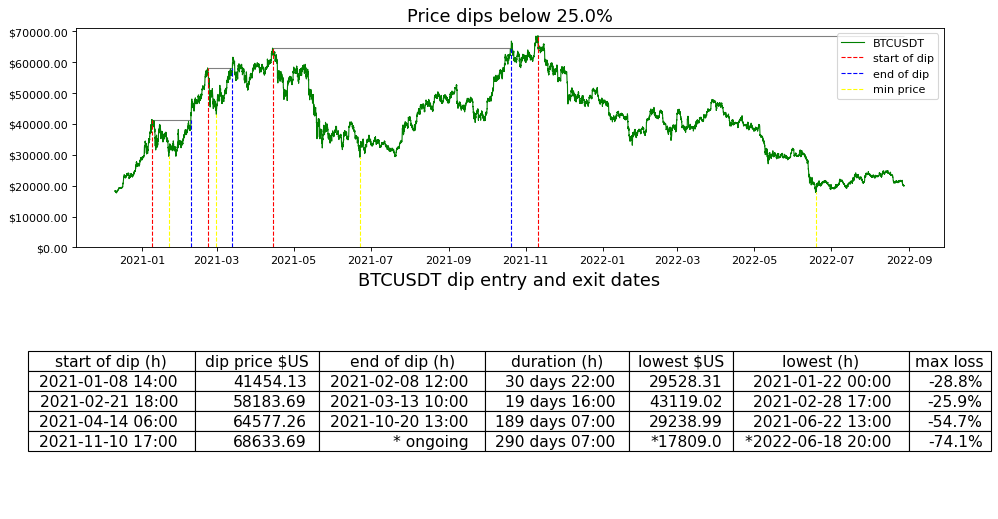

In [7]:
fig, ax = pyplot.subplots(2,1,figsize = (14, 8), dpi = 80)
ax[0].plot(series["date"],series["price"], color = "green", lw =  1)
ax[0].set_ylim(ymin=0)
ymx = ax[0].get_ybound()
ymin = ax[0].get_xbound()
for a, b, pricedip, priceout, minp, minpd in zip(coindipdate, dipstend, coindip, dipstendprice,minpricestack,mindipdate):
  ax[0].axvline(a, ymax= (pricedip- ymx[0])/(ymx[1]- ymx[0]), linestyle = "dashed", color = "red", lw = 1)
  ax[0].axvline(b, ymax= (priceout- ymx[0])/(ymx[1]- ymx[0]),  color = "blue", linestyle = "dashed", lw = 1)
  ax[0].axvline(minpd, ymax= (minp- ymx[0])/(ymx[1]- ymx[0]),  color = "yellow", linestyle = "dashed", lw = 1)
  if priceout == 0: 
    priceout = pricedip
  ax[0].fill_between([a,b], [pricedip, priceout], priceout , color = "grey", lw  = 1)

fmt = '$%1.2f' 
xticks = mtick.FormatStrFormatter(fmt)
ax[0].yaxis.set_major_formatter(xticks)

try:
    title = "Price dips below " + str(percentage * 100) + "%"
    ax[0].set_title(title)
    ax[0].legend([coin, "start of dip","end of dip","min price"])
    ax[1].set_axis_off()
    gg = pd.DataFrame(coindipdate, columns = ["startdip"])
    gg["price"] = coindip  
    gg["exit"] = dipstend  
    gg["daysdip"] = gg["exit"] - gg["startdip"]  
    gg["startdip"] = gg['startdip'].map(lambda t: str(t)[:-3])  # remove seconds
    gg["daysdip"] = gg['daysdip'].map(lambda t: str(t)[:-3])  # remove seconds
    gg["exit"] = gg['exit'].map(lambda t: str(t)[:-3])  # remove seconds
    gg["minprice"] = minpricestack
    gg["maxloss"] = (((gg["minprice"]/gg["price"]-1)*100).round(1)).map(lambda t: str(t) + "%")  
    gg["minprice"] =gg["minprice"].round(2)
    gg["price"] =gg["price"].round(2)
    gg["mindate"] = mindipdate
    gg["mindate"] = gg['mindate'].map(lambda t: str(t)[:-3])  # remove seconds
    gg = gg[["startdip","price","exit","daysdip","minprice","mindate","maxloss"]] # rearrange for the table
    if insidecoindip:
        gg.iloc[-1, gg.columns.get_loc('exit')] = "* ongoing"
        gg.iloc[-1, gg.columns.get_loc('minprice')] = "*" + str(gg.iloc[-1, gg.columns.get_loc('minprice')])
        gg.iloc[-1, gg.columns.get_loc('mindate')] = "*" + str(gg.iloc[-1, gg.columns.get_loc('mindate')])

    table = ax[1].table(cellText = gg.values,colLabels=["start of dip (h)","dip price $US","end of dip (h)","duration (h)","lowest $US", "lowest (h)", "max loss"], loc = "center")
    table.auto_set_column_width(col=list(range(len(gg.columns))))
    ax[1].set_title(coin + " dip entry and exit dates")

    ax[1].title.set_fontsize(16)
    ax[0].title.set_fontsize(16)
    table.set_fontsize(14)
    table.scale(1.5, 1.5)
except:
    print("no data for the table")
    pyplot.text(0.01, 0.9, 'no data for the table',{'size':'18'})

pyplot.show()